In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
import warnings; warnings.simplefilter('ignore')

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Load previously clean data
combined_df = pd.read_csv("/Users/lizamclatchy/ASCDP/Data Cleaning/Cleaned Model Input Data/aasu_rainintot_train.csv")
selected_columns = ['TIMESTAMP', 'Rain_in_Tot_Aasu'] + [col for col in combined_df.columns if col not in ['TIMESTAMP', 'Rain_in_Tot_Aasu']]
#Clean seperated df
rh_data = combined_df[selected_columns].copy()
rh_data = rh_data.dropna(subset=['Rain_in_Tot_Aasu'])  # Keep only rows where Rain_Aasu is not NaN
rh_data

,TIMESTAMP,Rain_in_Tot_Aasu,PTemp_C_Max_Aasu,AirTF_Avg_Aasu,SlrW_Avg_Aasu,SlrMJ_Tot_Aasu,RH_Aasu,PTemp_C_Max_Poloa,AirTF_Avg_Poloa,SlrW_Avg_Poloa,...,wind_direction_weighted_0,wind_speed_weighted_0,air_temp_weighted_0,relative_humidity_weighted_0,synoptic_elevation_0,wind_direction_weighted_1,wind_speed_weighted_1,air_temp_weighted_1,relative_humidity_weighted_1,synoptic_elevation_1
0,2019-06-17 11:15:00,0.0,32.33,78.02,513.500,0.462151,97.9,32.12,84.10,702.400,...,2.578017,0.110425,0.588406,1.674440,9.0,3.836020,0.032281,0.635543,2.434097,480.0
1,2019-06-17 11:30:00,0.0,33.94,79.48,575.600,0.518070,98.0,33.90,84.10,622.300,...,2.578017,0.110425,0.588355,1.674417,9.0,3.870214,0.032617,0.635543,2.434097,480.0
2,2019-06-17 11:45:00,0.0,35.19,79.89,550.900,0.495818,94.3,34.59,84.60,785.200,...,2.578017,0.110425,0.588647,1.674422,9.0,3.904230,0.035325,0.635543,2.434097,480.0
3,2019-06-17 12:00:00,0.0,36.16,81.00,559.500,0.503529,94.9,34.88,84.40,361.600,...,2.578017,0.110425,0.589184,1.679120,9.0,3.938903,0.039853,0.635543,2.434097,480.0
4,2019-06-17 12:15:00,0.0,36.14,80.10,309.400,0.278467,93.8,33.42,81.70,464.000,...,2.578017,0.110425,0.589721,1.689477,9.0,3.975742,0.043501,0.635543,2.434097,480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6849,2019-08-27 19:30:00,0.0,22.71,75.14,0.003,0.000002,93.0,25.84,77.77,0.005,...,2.656902,0.113235,0.595540,1.628890,9.0,4.381374,0.032617,0.622155,2.263710,480.0
6850,2019-08-27 19:45:00,0.0,22.55,74.74,0.003,0.000003,94.1,25.57,77.64,0.005,...,2.578017,0.110425,0.599389,1.626299,9.0,4.403816,0.032617,0.622488,2.275880,480.0
6851,2019-08-27 20:00:00,0.0,22.34,74.10,0.013,0.000012,95.1,25.36,77.74,0.005,...,2.465565,0.104072,0.597394,1.652017,9.0,4.438503,0.032617,0.621355,2.288051,480.0
6852,2019-08-27 20:15:00,0.0,21.98,74.49,0.011,0.000010,94.8,25.23,77.74,0.004,...,2.322901,0.093530,0.589567,1.709320,9.0,4.475051,0.032617,0.620622,2.300221,480.0


Creation of feature engineering terms

In [4]:
def feature_engineering(df):
    df = df.copy()
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    target_column = 'Rain_in_Tot_Aasu'
    #Do not want lags or non-relevant variab;es
    feature_cols = [col for col in df.columns if col not in ['TIMESTAMP', target_column,'Elevation_target','synoptic_elevation_1','synoptic_elevation_0']]   
    for col in feature_cols:
        df[f'{col}_lag1'] = df[col].shift(2)
        df[f'{col}_lag7'] = df[col].shift(7)
        df[f'{col}_rolling2'] = df[col].rolling(window=2).mean()
        df[f'{col}_rolling6'] = df[col].rolling(window=6).mean()
    
    #Time features
    df['hour_of_day'] = pd.to_datetime(df['TIMESTAMP']).dt.hour
    df['is_daytime'] = ((df['hour_of_day'] >= 6) & (df['hour_of_day'] <= 18)).astype(int)
    # Day of Week (0=Monday, 6=Sunday)
    df['day_of_week'] = df['TIMESTAMP'].dt.dayofweek
    # Season (simplified meteorological)
    df['month'] = df['TIMESTAMP'].dt.month

    # Heat Index (approximation using air temp and RH)
    if 'AirTF_target' in df.columns and 'RH_target' in df.columns:
        df['heat_index_target'] = df['AirTF_target'] * df['RH_target'] / 100
        df['temp_trend_1h_target'] = df['AirTF_target'].rolling(6).apply(lambda x: x.iloc[-1] - x.iloc[0], raw=False)
    for col in df.columns:
        if col != 'TIMESTAMP':
            df[col] = pd.to_numeric(df[col], errors='coerce')
 #Creation of interaction pairs based on feature importance plots to capture non-linearity 
    interaction_pairs = [
        ('weighted_Rain_in_Tot_Vapito', 'weighted_Rain_in_Tot_Poloa'),
        ('SlrMJ_Tot_Afono', 'RH_Aasu'),
        ('wind_speed_weighted_0', 'PTemp_C_Max_Poloa'),
    ]
    
    for col1, col2 in interaction_pairs:
        if col1 in df.columns and col2 in df.columns:
            df[f'{col1}__X__{col2}'] = df[col1] * df[col2]
    
    return df
fe_df = feature_engineering(rh_data)
fe_df

,TIMESTAMP,Rain_in_Tot_Aasu,PTemp_C_Max_Aasu,AirTF_Avg_Aasu,SlrW_Avg_Aasu,SlrMJ_Tot_Aasu,RH_Aasu,PTemp_C_Max_Poloa,AirTF_Avg_Poloa,SlrW_Avg_Poloa,...,relative_humidity_weighted_1_lag1,relative_humidity_weighted_1_lag7,relative_humidity_weighted_1_rolling2,relative_humidity_weighted_1_rolling6,hour_of_day,is_daytime,day_of_week,month,SlrMJ_Tot_Afono__X__RH_Aasu,wind_speed_weighted_0__X__PTemp_C_Max_Poloa
0,2019-06-17 11:15:00,0.0,32.33,78.02,513.500,0.462151,97.9,32.12,84.10,702.400,...,NaN,NaN,NaN,NaN,11,1,0,6,30.545456,3.546853
1,2019-06-17 11:30:00,0.0,33.94,79.48,575.600,0.518070,98.0,33.90,84.10,622.300,...,NaN,NaN,2.434097,NaN,11,1,0,6,27.683216,3.743410
2,2019-06-17 11:45:00,0.0,35.19,79.89,550.900,0.495818,94.3,34.59,84.60,785.200,...,2.434097,NaN,2.434097,NaN,11,1,0,6,12.892281,3.819603
3,2019-06-17 12:00:00,0.0,36.16,81.00,559.500,0.503529,94.9,34.88,84.40,361.600,...,2.434097,NaN,2.434097,NaN,12,1,0,6,28.984662,3.851626
4,2019-06-17 12:15:00,0.0,36.14,80.10,309.400,0.278467,93.8,33.42,81.70,464.000,...,2.434097,NaN,2.434097,NaN,12,1,0,6,43.311465,3.690406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6849,2019-08-27 19:30:00,0.0,22.71,75.14,0.003,0.000002,93.0,25.84,77.77,0.005,...,2.239369,2.158835,2.257625,2.232697,19,0,1,8,0.000419,2.925980
6850,2019-08-27 19:45:00,0.0,22.55,74.74,0.003,0.000003,94.1,25.57,77.64,0.005,...,2.251539,2.179277,2.269795,2.245454,19,0,1,8,0.000545,2.823569
6851,2019-08-27 20:00:00,0.0,22.34,74.10,0.013,0.000012,95.1,25.36,77.74,0.005,...,2.263710,2.199339,2.281966,2.257625,20,0,1,8,0.000235,2.639258
6852,2019-08-27 20:15:00,0.0,21.98,74.49,0.011,0.000010,94.8,25.23,77.74,0.004,...,2.275880,2.215028,2.294136,2.269795,20,0,1,8,0.000529,2.359770


Cross validation function

In [5]:
def cross_validate_model(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    train_scores, val_scores = [], []

    for train_idx, val_idx in tscv.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        train_pred = model.predict(X_tr)
        val_pred = model.predict(X_val)

        train_mae = mean_absolute_error(y_tr, train_pred)
        val_mae = mean_absolute_error(y_val, val_pred)

        train_scores.append(train_mae)
        val_scores.append(val_mae)

        print(f"Fold {len(train_scores)} - Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")

    return train_scores, val_scores

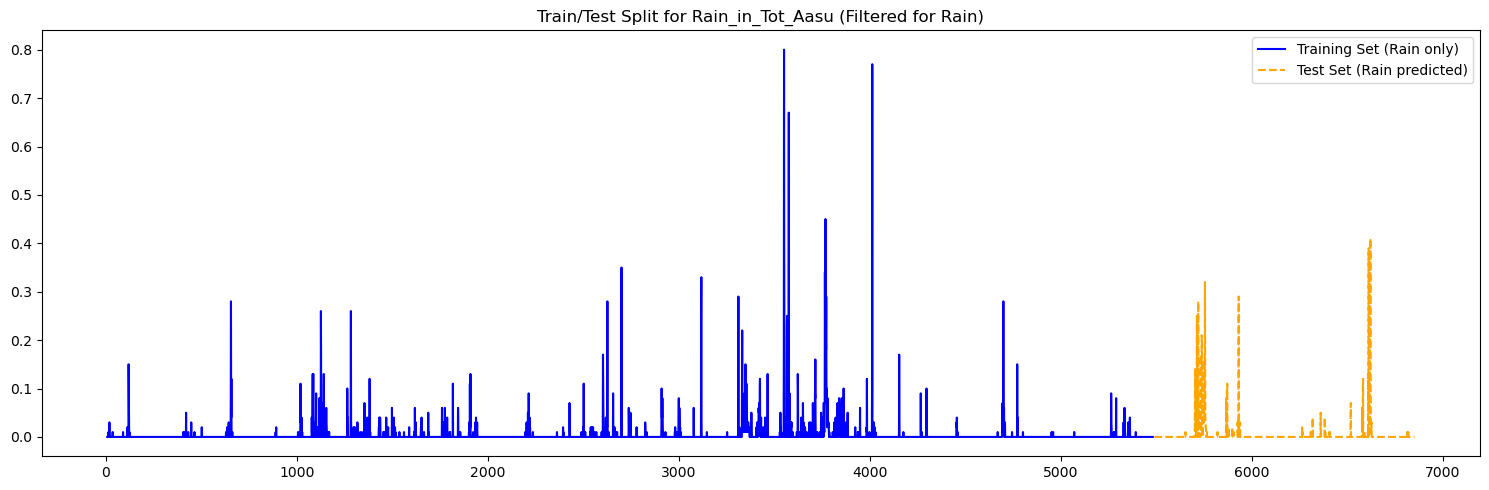

[I 2025-08-29 09:45:43,850] A new study created in memory with name: no-name-6a7675ac-086a-4ac5-941f-8b95e83a8320
[I 2025-08-29 09:45:44,407] Trial 0 finished with value: 0.008178922884658454 and parameters: {'n_estimators': 142, 'max_depth': 15, 'learning_rate': 0.02588423777732677, 'subsample': 0.6763551188218535, 'colsample_bytree': 0.5898058237646197, 'gamma': 0.6542180262721039, 'min_child_weight': 10, 'lambda': 0.007938994856697596, 'alpha': 0.004728755488354635}. Best is trial 0 with value: 0.008178922884658454.
[I 2025-08-29 09:45:47,064] Trial 1 finished with value: 0.008200500016611299 and parameters: {'n_estimators': 847, 'max_depth': 14, 'learning_rate': 0.014183267056549778, 'subsample': 0.9816558972013575, 'colsample_bytree': 0.9274871861490226, 'gamma': 0.7129116903990186, 'min_child_weight': 8, 'lambda': 9.07581629838468, 'alpha': 7.148382461114914}. Best is trial 0 with value: 0.008178922884658454.
[I 2025-08-29 09:45:49,754] Trial 2 finished with value: 0.008199122875

Best Params: {'n_estimators': 935, 'max_depth': 8, 'learning_rate': 0.015054019379499612, 'subsample': 0.8204815323730182, 'colsample_bytree': 0.9239018931694652, 'gamma': 0.0027961958072895976, 'min_child_weight': 7, 'lambda': 6.690993569879059, 'alpha': 0.692364945844636}
Fold 1 - Train MAE: 0.0027, Val MAE: 0.0059
Fold 2 - Train MAE: 0.0050, Val MAE: 0.0060
Fold 3 - Train MAE: 0.0041, Val MAE: 0.0105
Fold 4 - Train MAE: 0.0050, Val MAE: 0.0075
Fold 5 - Train MAE: 0.0049, Val MAE: 0.0027
Fold 1 - Train MAE: 0.0011, Val MAE: 0.0067
Fold 2 - Train MAE: 0.0008, Val MAE: 0.0036
Fold 3 - Train MAE: 0.0008, Val MAE: 0.0103
Fold 4 - Train MAE: 0.0010, Val MAE: 0.0066
Fold 5 - Train MAE: 0.0011, Val MAE: 0.0020


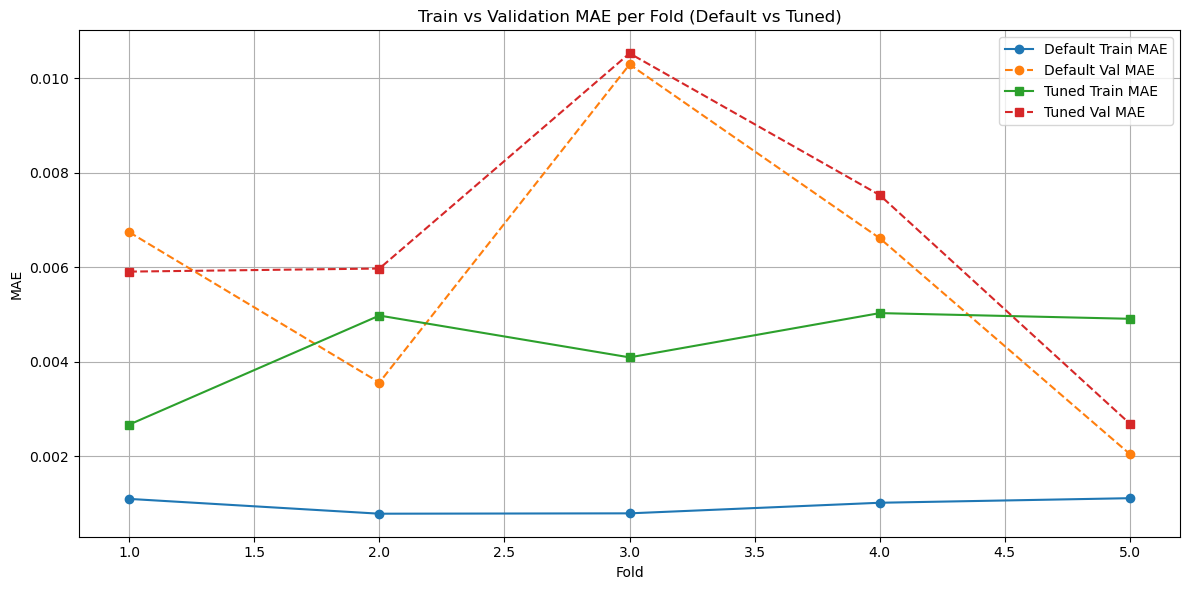

MAE (Linear): 0.01057012338925051
MAE: 0.0058 in
R²:    0.3968


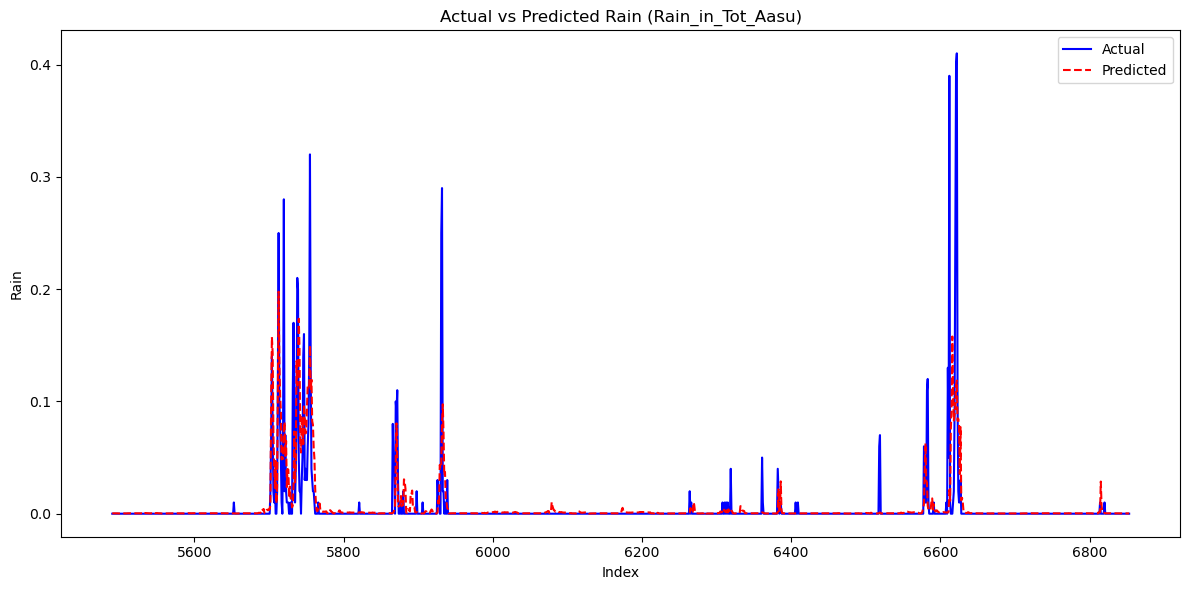

<Figure size 1000x600 with 0 Axes>

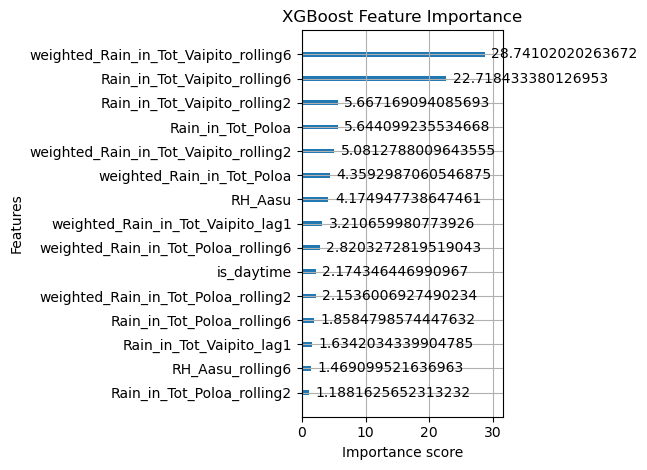

In [6]:
def xgboost_regression(train_df, target_column, n_splits=5):
    # --- 1. Prepare Data ---
    train_df = train_df.sort_values(by="TIMESTAMP")
    train_data, test_data = train_test_split(train_df, test_size=0.2, shuffle=False)
    train_data = feature_engineering(train_data).dropna()
    test_data = feature_engineering(test_data).dropna()
    # After feature_engineering


    X_train = train_data.drop(columns=[target_column, 'TIMESTAMP'])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column, 'TIMESTAMP'])
    y_test = test_data[target_column]

    # --- 2. Visualize Train-Test Split ---
    fig, ax = plt.subplots(figsize=(15, 5))

    # Plot using the actual index from y_train (already filtered)
    ax.plot(y_train.index, y_train, label='Training Set (Rain only)', color='blue')
    ax.plot(y_test.index, y_test, label='Test Set (Rain predicted)', linestyle="dashed", color='orange')
    
    ax.set_title(f'Train/Test Split for {target_column} (Filtered for Rain)')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # --- 3. Define Objective Function for Optuna with CV ---
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
            'objective': 'reg:squarederror',
            'random_state': 42
        }

        model = XGBRegressor(**params)
        tscv = TimeSeriesSplit(n_splits=n_splits)
        mae_scores = []
    
        for train_index, val_index in tscv.split(X_train):
            X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
            y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
            model.fit(X_tr, y_tr)
            preds = model.predict(X_val)
            mae_scores.append(mean_absolute_error(y_val, preds))
    
        return np.mean(mae_scores)

    # --- 4. Run Optuna ---
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    best_params = study.best_params
    print("Best Params:", best_params)

    # --- 5. Cross-Validate Best Model and Default Model ---
    best_model = XGBRegressor(
    **best_params,
    objective='reg:tweedie',
    tweedie_variance_power=1.2,  # try 1.1–1.8 range in Optuna later
    random_state=42
)
    default_model = XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.2 ,random_state=42)

    train_mae_best, val_mae_best = cross_validate_model(best_model, X_train, y_train, n_splits=n_splits)
    train_mae_default, val_mae_default = cross_validate_model(default_model, X_train, y_train, n_splits=n_splits)

    # --- 6. Plot CV Results ---
    folds = range(1, len(train_mae_best) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(folds, train_mae_default, 'o-', label='Default Train MAE')
    plt.plot(folds, val_mae_default, 'o--', label='Default Val MAE')
    plt.plot(folds, train_mae_best, 's-', label='Tuned Train MAE')
    plt.plot(folds, val_mae_best, 's--', label='Tuned Val MAE')
    plt.xlabel("Fold")
    plt.ylabel("MAE")
    plt.title("Train vs Validation MAE per Fold (Default vs Tuned)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 7. Fit Final Model and Evaluate ---
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_pred = np.clip(y_pred, a_min=0, a_max=None)

    from sklearn.linear_model import LinearRegression
    lr = LinearRegression().fit(X_train, y_train)
    print("MAE (Linear):", mean_absolute_error(y_test, lr.predict(X_test)))

    # smape_error = smape(y_test, y_pred)
    # print(f"SMAPE: {smape_error:.2f}%")
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.4f} in")
    print(f"R²:    {r2:.4f}")

    # --- 8. Plot Final Prediction ---
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--', color='red')
    plt.title(f'Actual vs Predicted Rain ({target_column})')
    plt.xlabel("Index")
    plt.ylabel("Rain")
    plt.legend()
    plt.tight_layout()
    plt.show()

    from xgboost import plot_importance

    plt.figure(figsize=(10, 6))
    plot_importance(best_model, importance_type='gain', max_num_features=15, title='XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()
    return best_model, y_test, y_pred, X_train, X_test, y_train, best_params

model, y_test, y_pred, X_train, X_test, y_train,best_params = xgboost_regression(rh_data, 'Rain_in_Tot_Aasu')

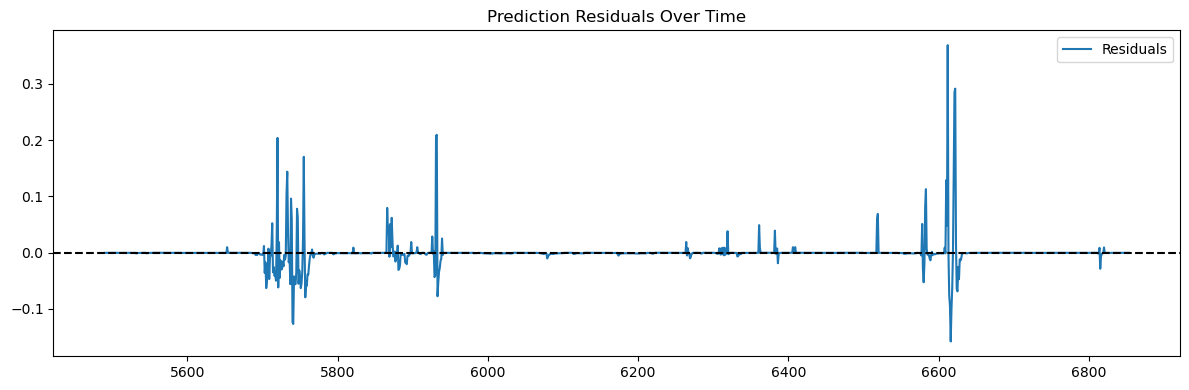

In [7]:
residuals = y_test - y_pred
plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.title("Prediction Residuals Over Time")
plt.legend()
plt.tight_layout()
plt.show()

   features       MAE        R²
0        20  0.006221  0.341272
1        40  0.006141  0.373765
2        60  0.006105  0.382825
3        80  0.006021  0.378153
4       100  0.005997  0.385928
5       150  0.005846  0.399508


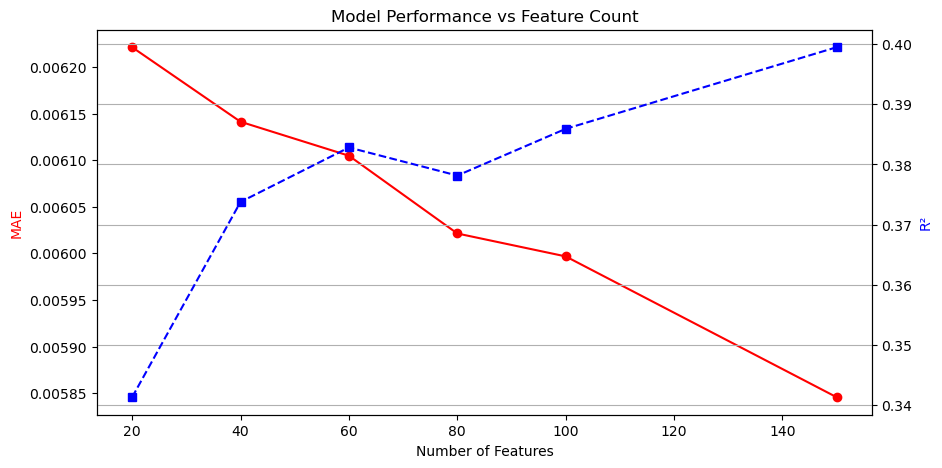

In [8]:
# --- Get feature importances from best_model ---
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# --- Evaluate with top N features ---
results = []
cutoffs = [20, 40, 60, 80, 100, 150]

for n in cutoffs:
    top_feats = importance_df.head(n)['feature'].tolist()

    model_temp = XGBRegressor(
        **best_params,
        objective='reg:tweedie',
        tweedie_variance_power=1.2,
        random_state=42
    )
    model_temp.fit(X_train[top_feats], y_train)
    preds = model_temp.predict(X_test[top_feats])

    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({'features': n, 'MAE': mae, 'R²': r2})

# --- Convert to DataFrame and plot ---
results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(10, 5))
plt.plot(results_df['features'], results_df['MAE'], 'o-', label='MAE', color='red')
plt.ylabel('MAE', color='red')
plt.xlabel('Number of Features')
plt.twinx()
plt.plot(results_df['features'], results_df['R²'], 's--', label='R²', color='blue')
plt.ylabel('R²', color='blue')
plt.title('Model Performance vs Feature Count')
plt.grid(True)
plt.show()
